In [546]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.covariance import MinCovDet
import statistics
import statsmodels.api as sm
import matplotlib.patches as mpatches


In [547]:
Courier_weekly_data = pd.read_csv("data/Courier_weekly_data.csv")
Courier_lifetime_data = pd.read_csv("data/Courier_lifetime_data.csv")

In [548]:
# Check the weather of categorical features, if some of them are needed to be assumed as continue or not.
cat_features = ['feature_1',
                'feature_2',
                'feature_3',
                'feature_11',
                'feature_16',
                'feature_17']
print(Courier_weekly_data.loc[:, cat_features].describe())

for feature_item in cat_features:
    print('The feature <{}> level size is {}'.format(feature_item, len(set(Courier_weekly_data.loc[:, feature_item]))))

# Note: I decided to eliminate the {'feature_11','feature_16','feature_17'}.
cat_dropped_features = ['feature_11', 'feature_16', 'feature_17']
Courier_weekly_data = Courier_weekly_data.drop(columns=cat_dropped_features)

         feature_1    feature_2    feature_3   feature_11   feature_16  \
count  4117.000000  4117.000000  4117.000000  4117.000000  4117.000000   
mean     -3.702453    44.232208    55.691037    20.266942     2.255526   
std      17.407331    24.007116    31.666550    12.460020     1.542969   
min    -138.000000     1.000000     1.000000     0.000000     1.000000   
25%     -12.000000    26.000000    31.000000    11.000000     1.000000   
50%      -2.000000    41.000000    51.000000    19.000000     2.000000   
75%       6.000000    59.000000    76.000000    28.000000     3.000000   
max      77.000000   169.000000   189.000000    86.000000    13.000000   

       feature_17  
count  4117.00000  
mean     12.78941  
std      11.69108  
min       1.00000  
25%       5.00000  
50%      10.00000  
75%      17.00000  
max     195.00000  
The feature <feature_1> level size is 140
The feature <feature_2> level size is 140
The feature <feature_3> level size is 165
The feature <feature_11> le

* Note: I treat the {'feature_1','feature_2','feature_3'} as continues.I think the {'feature_1','feature_2','feature_3'} are related to the number of the packages that are delivered by any person. 'feature_1' has to be 'feature_2' normalized.So, i just keep the 'feature_1'.

In [549]:
Courier_weekly_data = Courier_weekly_data.drop(columns=['feature_2'])

# Note: other categorical features are treated as float.
Courier_weekly_data = Courier_weekly_data.astype({"feature_1": float, "feature_3": float})

# Indexing the panel data
weeks = Courier_weekly_data['week']
couriers = Courier_weekly_data['courier']
Courier_weekly_data = Courier_weekly_data.drop(columns=['courier', 'week'])


# Outlier handling

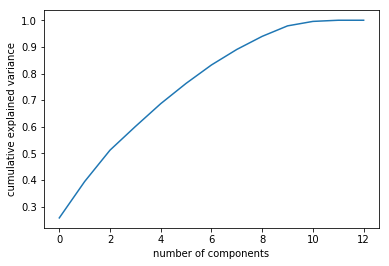

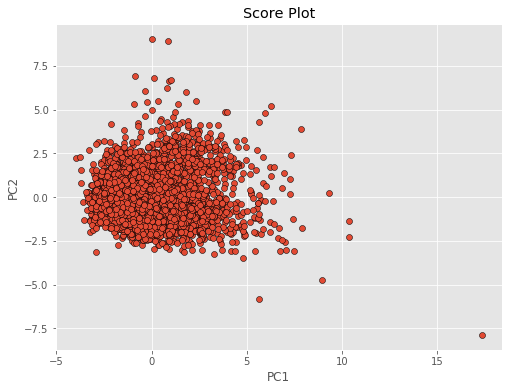

The first 8 component are describing the 90% of variance among the data.


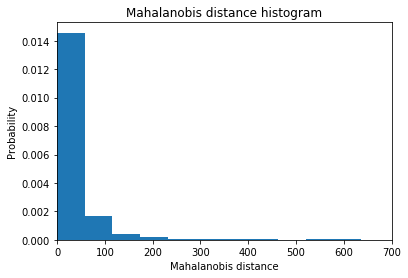

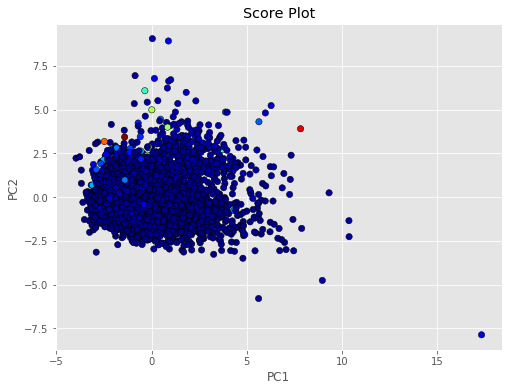

Mean of sample is: 38.417164478622674 
Standard Deviation of sample is: 119.15857294049124 
two standard deviation off the data is keep.
93 reacord <%2.2589264027204274> are deleted.


In [550]:
# Define the PCA object
pca = PCA()

# Run PCA on scaled data and obtain the scores array
T = pca.fit_transform(StandardScaler().fit_transform(Courier_weekly_data))
plt.plot(np.cumsum(pca.explained_variance_ratio_))
plt.xlabel('number of components')
plt.ylabel('cumulative explained variance')
plt.show()

# Score plot of the first 2 PC
fig = plt.figure(figsize=(8, 6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], edgecolors='k', cmap='jet')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()
print("The first 8 component are describing the 90% of variance among the data.")

# Mahalanobis distance for evaluating the overall distance of the outliers.
# fit a Minimum Covariance Determinant (MCD) robust estimator to data
robust_cov = MinCovDet().fit(T[:, :7])

# Get the Mahalanobis distance
m = robust_cov.mahalanobis(T[:, :7])
plt.hist(m, density=True, bins=50)
plt.ylabel('Probability')
plt.xlabel('Mahalanobis distance')
plt.title('Mahalanobis distance histogram')
plt.xlim(-1,700)
plt.show()

colors = [plt.cm.jet(float(i) / max(m)) for i in m]
fig = plt.figure(figsize=(8, 6))
with plt.style.context(('ggplot')):
    plt.scatter(T[:, 0], T[:, 1], c=colors, edgecolors='k', s=40)
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.title('Score Plot')
plt.show()

# Note: there are some outliers obviously in the plot of the first two PCA components. They are needed to be clean.
print("Mean of sample is: % s " % (statistics.mean(m)))
print("Standard Deviation of sample is: % s " % (statistics.stdev(m)))
print('two standard deviation off the data is keep.')

filter_bond = statistics.stdev(m) * 2 + statistics.mean(m)
old_df_sahpe = Courier_weekly_data.shape

Courier_weekly_data['week'] = weeks
Courier_weekly_data['courier'] = couriers
Courier_weekly_data['Mahalanobis_distance'] = m
Courier_weekly_data = Courier_weekly_data.sort_values(by=['Mahalanobis_distance'])
Courier_weekly_data = Courier_weekly_data.loc[Courier_weekly_data['Mahalanobis_distance'] < filter_bond]
new_df_sahpe = Courier_weekly_data.shape

print('{} reacord <%{}> are deleted.'.format(old_df_sahpe[0] - new_df_sahpe[0], 100 * (old_df_sahpe[0] - new_df_sahpe[
    0]) / old_df_sahpe[0]))

In [551]:
# Indexing the panel data
week = Courier_weekly_data['week']
courier = Courier_weekly_data['courier']
Courier_weekly_data = Courier_weekly_data.drop(columns=['Mahalanobis_distance'])
Courier_weekly_data_clean = Courier_weekly_data
Courier_weekly_data = Courier_weekly_data.set_index(['courier', 'week']).sort_index()


## Missing values handling

* There are two groups of incomplete instances in merged data set. 
    1. The ones have information about the courier in weekly table: in this case i use the regression for filling the missing value.
    1. The ones do not have information about the courier in weekly table:The missing value is filled by mean of groups {a,b,c}

The number of missing values in Courier_lifetime is: 936
Note: slice the data in two mentioned groups (without/with information)
(753, 15)
check the response variable (feature_2_lifetime) distribution.


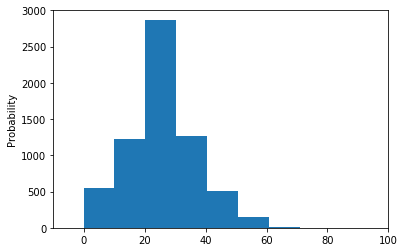

So it is close to Poisson.
--------------------------------------------------------------------------------
The Train data for missing value predication shape is: (693, 14)
The predicable data for missing value predication shape is: (60, 14)
--------------------------------------------------------------------------------
Note: The feature subset ['feature_1','feature_5','feature_9'] is omitted based on Z-test p_value (>0.05)
--------------------------------------------------------------------------------
                 Generalized Linear Model Regression Results                  
Dep. Variable:         feature_2_life   No. Observations:                  693
Model:                            GLM   Df Residuals:                      683
Model Family:                 Poisson   Df Model:                            9
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                   -inf
Date:           

/home/kaveh/.local/lib/python3.6/site-packages/ipykernel_launcher.py:52: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [552]:
Courier_weekly_data_mean = Courier_weekly_data.mean(level='courier', axis=0)
merged_df = pd.merge(Courier_lifetime_data, Courier_weekly_data_mean, how='left', on='courier')
merged_df = merged_df.set_index(['courier']).sort_index()

print('=' * 80)
print('The number of missing values in Courier_lifetime is:', merged_df[merged_df[
    'feature_2_life'].isnull()].shape[0])
print('=' * 80)

print('Note: slice the data in two mentioned groups (without/with information)')

# with information
merged_df_with_weekly_info = merged_df.loc[list(set(courier))]
print(merged_df_with_weekly_info.shape)

print('check the response variable (feature_2_lifetime) distribution.')
plt.hist(merged_df['feature_2_life'].dropna(), bins=100)
plt.ylabel('Probability')
plt.xlim((-10, 100))
plt.ylim((0, 3000))
Todo: plt.show()
print('So it is close to Poisson.')

merged_df_with_weekly_info_feature_1_life = merged_df_with_weekly_info['feature_1_life']
merged_df_with_weekly_info = merged_df_with_weekly_info.drop(columns=['feature_1_life'])

merged_df_with_weekly_info_pred = merged_df_with_weekly_info[merged_df_with_weekly_info[
    'feature_2_life'].isnull()]
merged_df_with_weekly_info_train = merged_df_with_weekly_info.dropna(subset=['feature_2_life'])

print('-' * 80)
print('The Train data for missing value predication shape is:', merged_df_with_weekly_info_train.shape)
print('The predicable data for missing value predication shape is:', merged_df_with_weekly_info_pred.shape)
print('-' * 80)

print("Note: The feature subset ['feature_1','feature_5','feature_9'] is omitted based on Z-test p_value (>0.05)")

data_endog = merged_df_with_weekly_info_train['feature_2_life']
data_exog = merged_df_with_weekly_info_train.drop(columns=['feature_2_life', 'feature_1', 'feature_5', 'feature_9'])

pred_endog = []
pred_exog = merged_df_with_weekly_info_pred.drop(columns=['feature_2_life', 'feature_1', 'feature_5', 'feature_9'])

# Instantiate a gamma family model with the default link function.
Poisson_model = sm.GLM(data_endog, data_exog, family=sm.families.Poisson())
Poisson_results = Poisson_model.fit()
print('-' * 80)
print(Poisson_results.summary())
print('-' * 80)

Poisson_model_pred = round(Poisson_results.predict(pred_exog))
merged_df_with_weekly_info_pred['feature_2_life'] = Poisson_model_pred

# Reconstruct the merged_df_with_weekly_info
merged_df_with_weekly_info = pd.concat([merged_df_with_weekly_info_pred,
                                        merged_df_with_weekly_info_train])
merged_df_with_weekly_info['feature_1_life'] = merged_df_with_weekly_info_feature_1_life


# without information
merged_df_without_weekly_info = merged_df.drop(list(set(courier)))
lifetime_imputed = pd.concat([merged_df_without_weekly_info[['feature_1_life', 'feature_2_life']],
                              merged_df_with_weekly_info[['feature_1_life', 'feature_2_life']]])

print('=' * 80)
print('The number of missing values is:', lifetime_imputed[lifetime_imputed[
    'feature_2_life'].isnull()].shape[0])
print('Equal to: %', 100 * lifetime_imputed[lifetime_imputed[
    'feature_2_life'].isnull()].shape[0] / lifetime_imputed.shape[0])
print('Note: There is interaction between the feature_1_life and feature_2_life '
      '(overlap between confidence intervals)then it is imposable to impute missing'
      ' values in feature_2_life with assuming the feature_1_life.'
      'So, the rest of recodes with missing values are needed to be deleted.')
print('=' * 80)

# Note: the rest of them are imputed by the mean of any group

print(lifetime_imputed.groupby(['feature_1_life']).mean())
print(lifetime_imputed.groupby(['feature_1_life']).std())

In [553]:
'''
Note: The mean of different group (a,b,c,d) is very close nad the confidence interval is to wide.
      I prefer not to impute by mean of categories. It is not a good approach. 
      On the same hand, The data set is big enough for eliminating 11% of the data.
'''
lifetime_imputed = lifetime_imputed.dropna(subset=['feature_2_life'])

print('=' * 80)
print('The final shape of the lifetime data set is:', lifetime_imputed.shape)

Courier_weekly_data_clean = pd.merge(Courier_weekly_data_clean, lifetime_imputed, how='left', on='courier')

print('The final shape of the weekly data set is:', Courier_weekly_data_clean.shape)
print('=' * 80)

The final shape of the lifetime data set is: (6648, 2)
The final shape of the weekly data set is: (4024, 17)


# Feature Relation


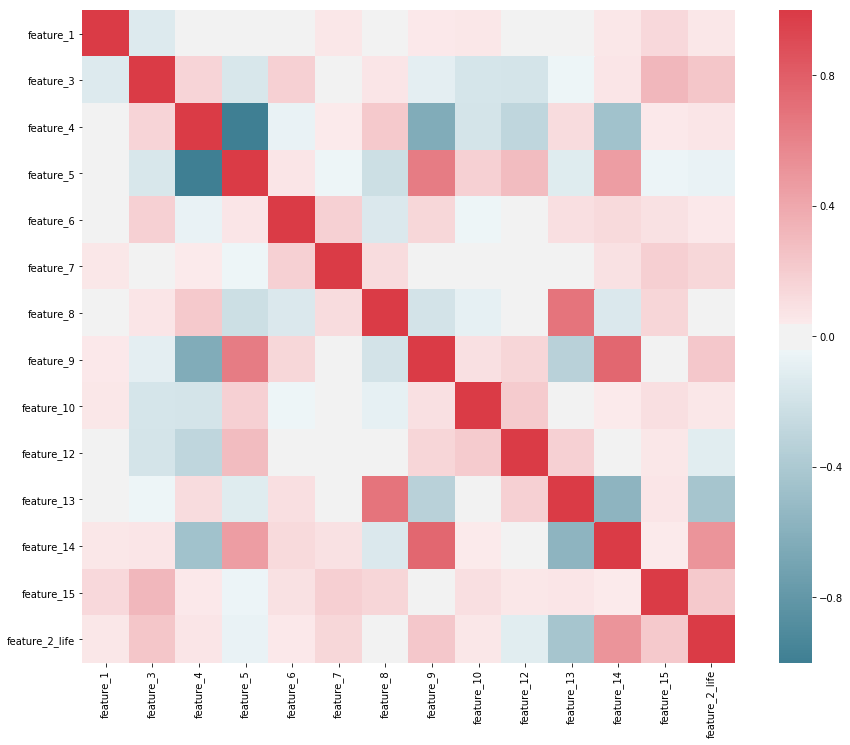

In [554]:
import seaborn as sns
fig = plt.figure(figsize=(16, 12))
corr = Courier_weekly_data_clean.drop(['courier', 'week'],axis=1).corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True)
plt.show()


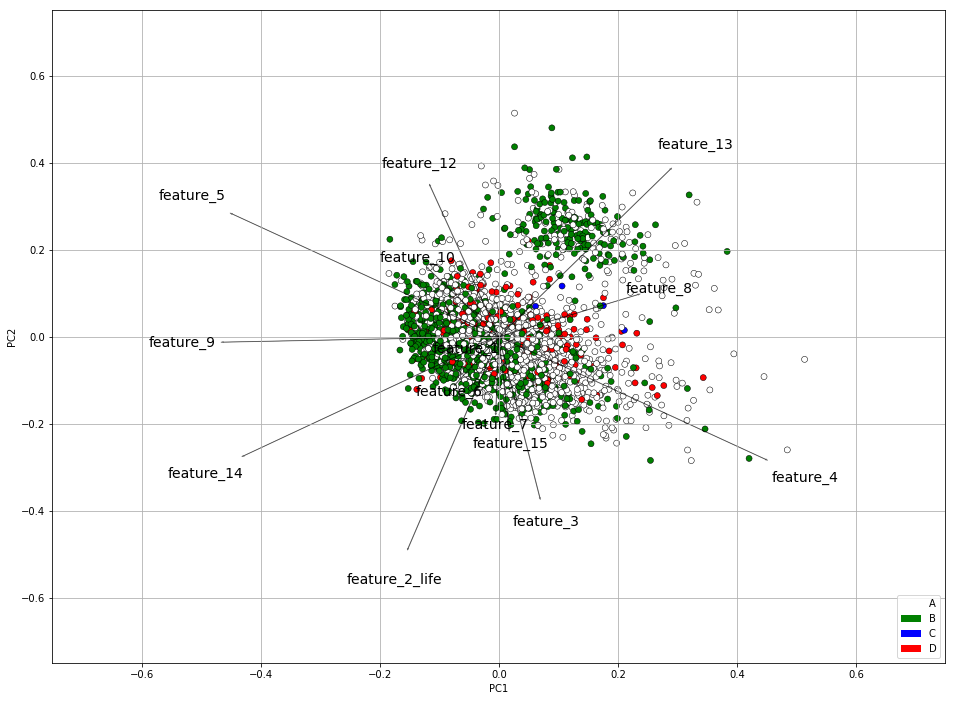

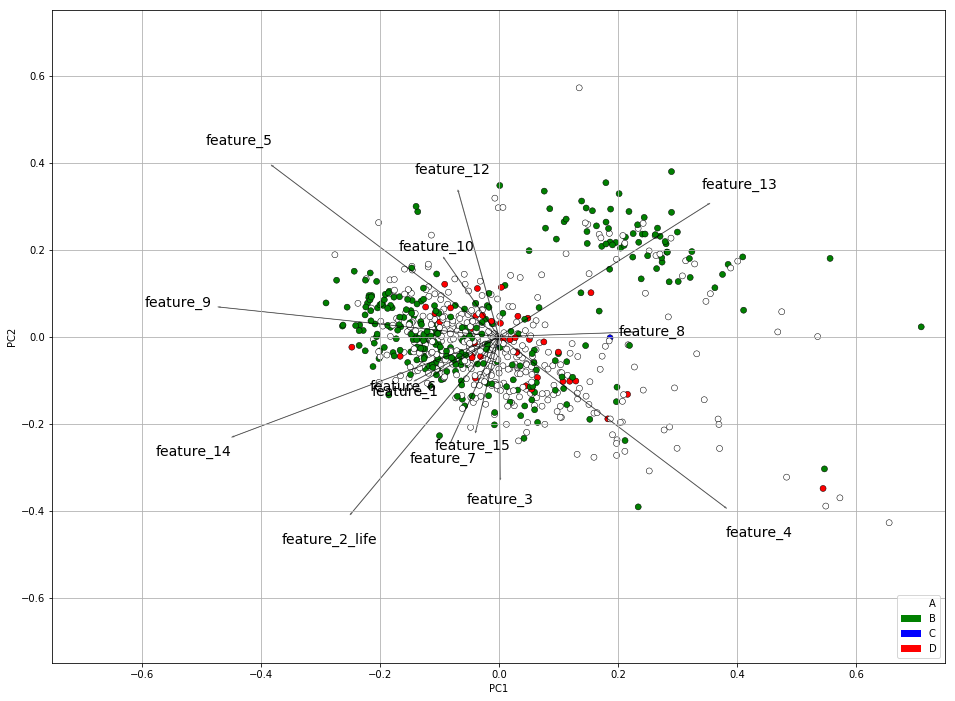

In [555]:
Courier_weekly_data_mean = Courier_weekly_data_clean.drop(columns=['feature_1_life'], axis=1).set_index(['courier', 'week']).mean(level='courier', axis=0)
merged_weekly_with_label = pd.merge(Courier_weekly_data, Courier_lifetime_data, how='left', on='courier')[
    'feature_1_life']

columns_item=Courier_weekly_data_clean.drop(columns=['feature_1_life'], axis=1).set_index(['courier', 'week']).columns

merged_weekly_with_label = np.where(merged_weekly_with_label == 'a', 'w', merged_weekly_with_label)
merged_weekly_with_label = np.where(merged_weekly_with_label == 'b', 'green', merged_weekly_with_label)
merged_weekly_with_label = np.where(merged_weekly_with_label == 'c', 'blue', merged_weekly_with_label)
merged_weekly_with_label = np.where(merged_weekly_with_label == 'd', 'red', merged_weekly_with_label)

pca = PCA()
T = pca.fit_transform(StandardScaler().fit_transform(Courier_weekly_data_clean.drop(columns=['feature_1_life'], axis=1).set_index(['courier', 'week']).sort_index()))


# Score plot of the first 2 PC


def myplot(score, coeff, labels=None, colored=True, cc=merged_weekly_with_label):
    xs = score[:, 0]
    ys = score[:, 1]
    n = coeff.shape[0]
    scalex = 1.0 / (xs.max() - xs.min())
    scaley = 1.0 / (ys.max() - ys.min())
    with plt.style.context(('ggplot')):
        if colored:
            plt.scatter(xs * scalex, ys * scaley, c=cc, edgecolors='k', cmap='jet')
            for i in range(n):
                plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='black', alpha=0.5)
                if labels is None:
                    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color='black', ha='center',
                             va='center')
                else:
                    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='black', ha='center', va='center',
                             fontsize=14)
        else:
            plt.scatter(xs * scalex, ys * scaley, edgecolors='k', cmap='jet')
            for i in range(n):
                plt.arrow(0, 0, coeff[i, 0], coeff[i, 1], color='black', alpha=0.5)
                if labels is None:
                    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, "Var" + str(i + 1), color='black', ha='center',
                             va='center')
                else:
                    plt.text(coeff[i, 0] * 1.15, coeff[i, 1] * 1.15, labels[i], color='black', ha='center', va='center')


fig = plt.figure(figsize=(16, 12))
plt.xlim(-0.75, 0.75)
plt.ylim(-0.75, 0.75)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

classes = ['A','B','C','D']
class_colours = ['w','g','b','r']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4)

# Call the function. Use only the 2 PCs.
myplot(T[:, 0:2], np.transpose(pca.components_[0:2, :]), labels=columns_item, cc=merged_weekly_with_label)
plt.show()

# psc for summary data
merged_weekly_with_label = pd.merge(Courier_weekly_data_mean, lifetime_imputed, how='left', on='courier')[
    'feature_1_life']

merged_weekly_with_label = np.where(merged_weekly_with_label == 'a', 'w', merged_weekly_with_label)
merged_weekly_with_label = np.where(merged_weekly_with_label == 'b', 'green', merged_weekly_with_label)
merged_weekly_with_label = np.where(merged_weekly_with_label == 'c', 'blue', merged_weekly_with_label)
merged_weekly_with_label = np.where(merged_weekly_with_label == 'd', 'red', merged_weekly_with_label)


pca = PCA()
T = pca.fit_transform(StandardScaler().fit_transform(Courier_weekly_data_mean))
# Score plot of the first 2 PC

fig = plt.figure(figsize=(16, 12))
plt.xlim(-0.75, 0.75)
plt.ylim(-0.75, 0.75)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

classes = ['A','B','C','D']
class_colours = ['w','g','b','r']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4)

# Call the function. Use only the 2 PCs.
myplot(T[:, 0:2], np.transpose(pca.components_[0:2, :]), labels=columns_item,cc=merged_weekly_with_label)
plt.show()

1. THe features 4 and 5 are correlated(negatively) significantly   
1. THe features 13 and 14 are correlated(negatively) significantly
1. THe features 12 and 3 are correlated(negatively) significantly
1. THe features 12 and 3 are correlated(negatively) significantly  
1. THe feature 9 significantly is aliened with the first import ant PCA component.
1. THe feature 2_life significantly is aliened with the second import ant PCA component.
1. Feature_9 and feature_2_life are important feature that should take to account in modeling part.
2. The feature 1,6,7,10 and 15 are not very significance features, they are the first candidates for eliminating from the feature set.

# Modeling

In [556]:
# prepare the data set

# Note: extract the '0/1' labels.
df_labs = Courier_weekly_data_clean[(Courier_weekly_data_clean.week > 8) & (Courier_weekly_data_clean.week < 12)][
    ['courier']]
df_labs = list(set(df_labs['courier']))

Courier_weekly_data_clean['label'] = 0
Courier_weekly_data_clean.loc[Courier_weekly_data_clean['courier'].isin(df_labs), 'label'] = 1

# Delete the 8,9,10,11
Courier_weekly_data_clean = Courier_weekly_data_clean[
    (Courier_weekly_data_clean.week < 7) | (Courier_weekly_data_clean.week > 12)]

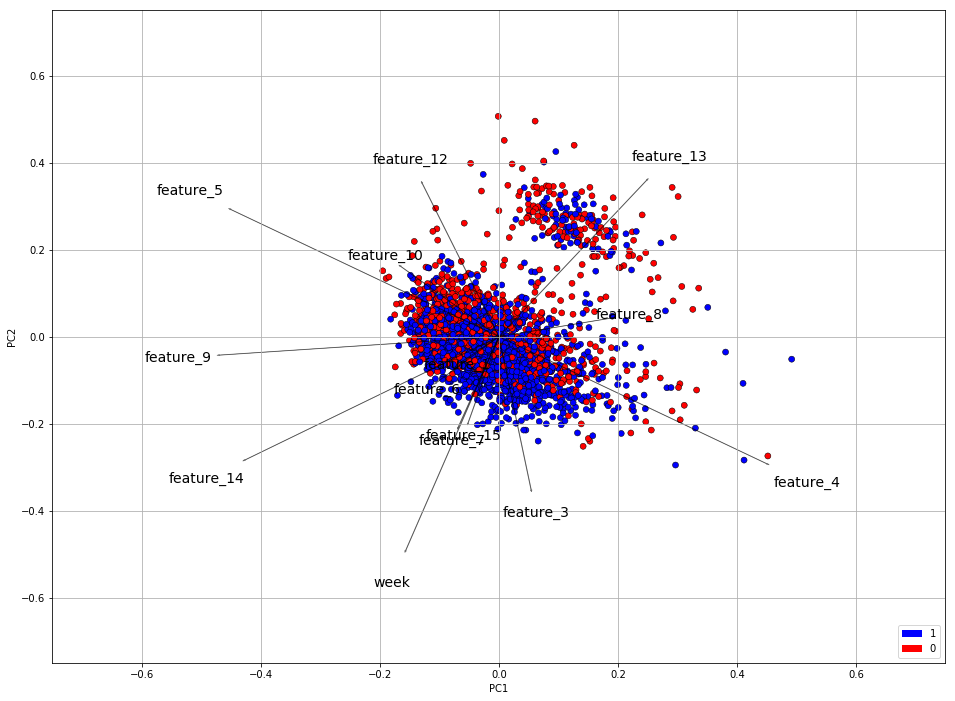

In [557]:
# psc for summary data
merged_weekly_with_label = Courier_weekly_data_clean['label']

merged_weekly_with_label = np.where(merged_weekly_with_label == 0, 'r', merged_weekly_with_label)
merged_weekly_with_label = np.where(merged_weekly_with_label == '1', 'b', merged_weekly_with_label)

pca = PCA()
T = pca.fit_transform(StandardScaler().fit_transform(Courier_weekly_data_clean.drop(columns=['feature_1_life','week','courier','label'])))

# Score plot of the first 2 PC

fig = plt.figure(figsize=(16, 12))
plt.xlim(-0.75, 0.75)
plt.ylim(-0.75, 0.75)
plt.xlabel("PC{}".format(1))
plt.ylabel("PC{}".format(2))
plt.grid()

classes = ['1','0']
class_colours = ['b','r']
recs = []
for i in range(0,len(class_colours)):
    recs.append(mpatches.Rectangle((0,0),1,1,fc=class_colours[i]))
plt.legend(recs,classes,loc=4)

# Call the function. Use only the 2 PCs.
myplot(T[:, 0:2], np.transpose(pca.components_[0:2, :]), labels=Courier_weekly_data_clean.columns,cc=merged_weekly_with_label)
plt.show()


#  Imbalanced Classes


In [558]:
print(Courier_weekly_data_clean.groupby(['label']).size())


label
0     947
1    1695
dtype: int64


* It is needed to mitigate the class imbalance for abounding the bios.

In [559]:
from sklearn.utils import resample

# Separate majority and minority classes
df_majority = Courier_weekly_data_clean[Courier_weekly_data_clean.label==1]
df_minority = Courier_weekly_data_clean[Courier_weekly_data_clean.label==0]
 
# Up sample minority class
df_minority_upsampled = resample(df_minority, 
                                 replace=True,     # sample with replacement
                                 n_samples=1694,    # to match majority class
                                 random_state=4) # reproducible results
 
# Combine majority class with up sampled minority class
df_upsampled = pd.concat([df_majority, df_minority_upsampled])
 
Courier_weekly_data_clean=df_upsampled.copy()
print('new class counts:')
print(Courier_weekly_data_clean.groupby(['label']).size())



new class counts:
label
0    1694
1    1695
dtype: int64


In [560]:
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.metrics import accuracy_score, mean_squared_error, average_precision_score, recall_score, \
    classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
import statsmodels.api as sm
import statsmodels.formula.api as smf


In [561]:
def validation_report(predictions, y_test):
    # Calculate the absolute errors
    errors = abs(predictions - y_test)

    # result_accuracy.at[name, fs_item] = accuracy_score(predictions, y_test)
    print('-' * 50)
    print('Mean Absolute Error:', round(np.mean(errors), 2), 'degrees.')
    print('Accuracy:', accuracy_score(predictions, y_test))
    print('Normalized Accuracy:', accuracy_score(predictions, y_test, normalize=False))
    print('Mean squared error:', mean_squared_error(predictions, y_test))
    print('average_precision:', average_precision_score(predictions, y_test))
    print('recall_score:', recall_score(predictions, y_test))
    print('recall_score:', classification_report(predictions, y_test))
    print('-' * 50)


* Prepare data fro the modeling

In [562]:
Courier_weekly_data_clean_ = Courier_weekly_data_clean.set_index(['courier', 'week']).sort_index()
df = Courier_weekly_data_clean.copy()
labs = df['label']
abcd = df['feature_1_life']
df = df.drop(['label', 'feature_1_life'], axis=1)
df_ordinal = df.copy(deep=True)
cols = df.columns
df = StandardScaler().fit_transform(df)
df = pd.DataFrame(data=df, columns=cols)
# Saving feature names for later use
feature_list = list(df.columns)
# Convert to numpy array
df = np.array(df)


/home/kaveh/.local/lib/python3.6/site-packages/sklearn/preprocessing/data.py:645: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/kaveh/.local/lib/python3.6/site-packages/sklearn/base.py:464: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


* add interaction to model

In [563]:
poly = PolynomialFeatures(interaction_only=True, include_bias=True)
df = poly.fit_transform(df)
# Labels are the values we want to predict
labels = np.array(labs)
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df, labels, test_size=0.25,
                                                    random_state=42)
print('Training Features Shape:', X_train.shape)
print('Training Labels Shape:', y_train.shape)
print('Validating Features Shape:', X_test.shape)
print('Validating Labels Shape:', y_test.shape)


Training Features Shape: (2541, 137)
Training Labels Shape: (2541,)
Validating Features Shape: (848, 137)
Validating Labels Shape: (848,)


### <span style="color:red">Warning: it is not a good idea to run it on Jupiter.</span>


In [ ]:
from sklearn.kernel_ridge import KernelRidge

names = ["Nearest Neighbors", "Linear SVM", "RBF SVM",
         "Decision Tree", "Random Forest", "Neural Net", "AdaBoost",
         "Naive Bayes", "QDA", "LogisticRegression", "Kernel Ridge"]

classifiers = [
    KNeighborsClassifier(weights='distance', n_neighbors=50, algorithm='auto'),
    SVC(kernel="linear", C=0.025),
    SVC(),
    DecisionTreeClassifier(max_depth=5),
    RandomForestClassifier(max_depth=10, n_estimators=30, max_features=5),
    MLPClassifier(alpha=1),
    AdaBoostClassifier(),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
    LogisticRegression(solver='liblinear'),
    KernelRidge(alpha=3)]

# iterate over classifiers
for name, clf in zip(names, classifiers):
    print('===============', name, '==================')
    clf.fit(X_train, y_train)
    score = clf.score(X_test, y_test)

    # ----------------------------validation---------------------
    predictions = clf.predict(X_test)
    predictions = np.around(np.array(predictions))
    validation_report(predictions,y_test)


* the result shows the ANN and Random forest are the best chooses.

In [564]:
clf=RandomForestClassifier(max_depth=10, n_estimators=30, max_features=5)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
predictions = clf.predict(X_test)
predictions = np.around(np.array(predictions))
validation_report(predictions, y_test)

base_accuracy_RF=accuracy_score(predictions, y_test)


--------------------------------------------------
Mean Absolute Error: 0.18 degrees.
Accuracy: 0.8242924528301887
Normalized Accuracy: 699
Mean squared error: 0.17570754716981132
average_precision: 0.7686062307034851
recall_score: 0.8395348837209302
recall_score:               precision    recall  f1-score   support

           0       0.83      0.81      0.82       418
           1       0.82      0.84      0.83       430

   micro avg       0.82      0.82      0.82       848
   macro avg       0.82      0.82      0.82       848
weighted avg       0.82      0.82      0.82       848

--------------------------------------------------


In [565]:
clf=MLPClassifier(alpha=1)
clf.fit(X_train, y_train)
score = clf.score(X_test, y_test)
predictions = clf.predict(X_test)
predictions = np.around(np.array(predictions))
validation_report(predictions, y_test)
base_accuracy_ANN=accuracy_score(predictions, y_test)


--------------------------------------------------
Mean Absolute Error: 0.17 degrees.
Accuracy: 0.8254716981132075
Normalized Accuracy: 700
Mean squared error: 0.17452830188679244
average_precision: 0.7361065221822938
recall_score: 0.8746803069053708
recall_score:               precision    recall  f1-score   support

           0       0.88      0.78      0.83       457
           1       0.78      0.87      0.82       391

   micro avg       0.83      0.83      0.83       848
   macro avg       0.83      0.83      0.83       848
weighted avg       0.83      0.83      0.83       848

--------------------------------------------------


* Both ANN and Random forest are tacked to account, I do the tuning on both.

In [566]:
# Tune two models one by one.
X_train_rf=X_train.copy()
X_test_rf=X_test.copy()

X_train_ann=X_train.copy()
X_test_ann=X_test.copy()



# Tuning the hyper parameters of model Grid Search

### Random forest model tuning


### <span style="color:red">Warning: it is not a good idea to run it on Jupiter.</span>

In [ ]:
from sklearn.model_selection import RandomizedSearchCV

# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 200, stop = 2000, num = 10)]
# Number of features to consider at every split
max_features = ['auto', 'sqrt']
# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 110, num = 11)]
max_depth.append(None)
# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10]
# Minimum number of samples required at each leaf node
min_samples_leaf = [1, 2, 4]
# Method of selecting samples for training each tree
bootstrap = [True, False]
# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}
print(random_grid)
# Use the random grid to search for best hyper parameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, 
                               param_distributions = random_grid, 
                               n_iter = 20, cv = 5, verbose=2, 
                               random_state=42, n_jobs = -1)

# Fit the random search model
rf_random.fit(X_train, y_train)
print(rf_random.best_params_)


### Optimal random forest model
*  'n_estimators': 800,
*  'min_samples_split': 2, 
*  'min_samples_leaf': 1, 
*  'max_features': 'sqrt', 
*  'max_depth': 20, 
*  'bootstrap': False

In [567]:
clf=RandomForestClassifier(max_depth=20, 
                           n_estimators=800, 
                           max_features='sqrt',
                           min_samples_split=2,
                           bootstrap=False,
                           min_samples_leaf= 1)
clf.fit(X_train_rf, y_train)
score = clf.score(X_test_rf, y_test)
predictions = clf.predict(X_test_rf)
predictions = np.around(np.array(predictions))
validation_report(predictions, y_test)
final_accuracy_RF=accuracy_score(predictions, y_test)
print('Random Forest model: Improvement of {:0.2f}%.'.format( 100 * (final_accuracy_RF - base_accuracy_RF) / base_accuracy_RF))


--------------------------------------------------
Mean Absolute Error: 0.1 degrees.
Accuracy: 0.8962264150943396
Normalized Accuracy: 760
Mean squared error: 0.10377358490566038
average_precision: 0.8654812380750476
recall_score: 0.8966292134831461
recall_score:               precision    recall  f1-score   support

           0       0.89      0.90      0.89       403
           1       0.90      0.90      0.90       445

   micro avg       0.90      0.90      0.90       848
   macro avg       0.90      0.90      0.90       848
weighted avg       0.90      0.90      0.90       848

--------------------------------------------------
Random Forest model: Improvement of 8.73%.


## ANN model tuning

### <span style="color:red">Warning: it is not a good idea to run it on Jupiter.</span>

In [ ]:
from sklearn.model_selection import GridSearchCV
mlp = MLPClassifier(max_iter=100)
parameter_space = {
    'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,)],
    'activation': ['tanh', 'relu', 'logistic'],
    'solver': ['sgd', 'adam'],
    'alpha': [0.0001, 0.05],
    'learning_rate': ['constant','adaptive']}
clf = GridSearchCV(mlp, parameter_space, n_jobs=-1, cv=3)
clf.fit(X_train, y_train)

# Best hyper parameter set
print('Best parameters found:\n', clf.best_params_)

### Optimal ANN model
* 'activation': 'tanh' 
* 'alpha': 0.05
* 'hidden_layer_sizes': (100,)
* 'learning_rate': 'constant'
* 'solver': 'lbfgs'


In [568]:
clf=MLPClassifier(activation='relu',
                  alpha=0.9,
                  hidden_layer_sizes= (100,),
                  learning_rate='adaptive', 
                  solver='adam')

clf.fit(X_train_ann, y_train)
score = clf.score(X_test_ann, y_test)
predictions = clf.predict(X_test_ann)
predictions = np.around(np.array(predictions))
validation_report(predictions, y_test)
final_accuracy_ANN=accuracy_score(predictions, y_test)
print('ANN model: Improvement of {:0.2f}%.'.format( 100 * (final_accuracy_ANN - base_accuracy_ANN) / base_accuracy_ANN))


--------------------------------------------------
Mean Absolute Error: 0.17 degrees.
Accuracy: 0.8278301886792453
Normalized Accuracy: 702
Mean squared error: 0.1721698113207547
average_precision: 0.7322832330133886
recall_score: 0.8851174934725848
recall_score:               precision    recall  f1-score   support

           0       0.89      0.78      0.83       465
           1       0.77      0.89      0.82       383

   micro avg       0.83      0.83      0.83       848
   macro avg       0.83      0.83      0.83       848
weighted avg       0.84      0.83      0.83       848

--------------------------------------------------
ANN model: Improvement of 0.29%.


/home/kaveh/.local/lib/python3.6/site-packages/sklearn/neural_network/multilayer_perceptron.py:562: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  % self.max_iter, ConvergenceWarning)


# <span style="color:blue"> Conclusion </span>

* The selected model: The Random Forest model is selected as model that is more fitted to the data because:
    * The accuracy of the model is higher than 90% (ANN ~ 84%)
    * The ANN ones has significant precision imbalance among classes ('1': 77%, '0': 91%), 
      then it is not a suitable model for predicting class '1'. In contrast, the precision of 
      Random Forest model not only is higher both also for both class is more similar. ('1': 88%, '0': 91%).
    * Both methods are non-parametric and the common difficulty whit this group of method is interpreting the model.
      Random Forest model is more interpretable in comparison with ANN.
 
### <span style="color:g"> Extra model </span>
* Rejected:
       The response variable has binomial distribution, then glm (GAM) should be a good choose at first glance. 
       But, i find glm_GAM is not satisfactory.

In [569]:
# Logistic regression 
train, test = train_test_split(Courier_weekly_data_clean, test_size=0.25)
formula = 'label ~ feature_1+feature_3+feature_4+feature_5+feature_6+feature_7+feature_8+feature_12+' \
          'feature_14+feature_15+feature_2_life'

Poisson_model = smf.glm(formula=formula, data=train, family=sm.families.Binomial())
Poisson_results = Poisson_model.fit()
print('*' * 50)
print(Poisson_results.summary())
print('*' * 50)
predictions = round(Poisson_results.predict(test))
validation_report(predictions , test['label'])



**************************************************
                 Generalized Linear Model Regression Results                  
Dep. Variable:                  label   No. Observations:                 2541
Model:                            GLM   Df Residuals:                     2529
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1442.2
Date:                Fri, 29 Mar 2019   Deviance:                       2884.4
Time:                        16:53:25   Pearson chi2:                 2.56e+03
No. Iterations:                     4   Covariance Type:             nonrobust
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
Intercept      -3285.7199   4691.957     -0.700      0.484   -1.25e+04  